# Reverse AFM Height Map Search: Content-Based Topography Retrieval via Self-Supervised Deep Learning
## Marcus Schwarting, Matthew JL Mills, Mahsa Lotfollahi, Maryam Pardakhti, KJ Schmidt, Bahram Rajabifar, Bjorn Melin, Hyacinth Lechuga, Ben Blaiszik and Ian Foster


This repository contains example data and code demonstrating how to reproduce the data pre-processing and model building procedures defined in the above paper. The first section shows how data is read from files and subsequently processed through carefully defined analytical pipelines, then saved to .png images ready for model building. The second section shows how the SIFT-BOW models were created using the processed image files, and finally the creation of DINO models is shown.

## 1. Process Raw Height Map Data

### Read the AFM Height Maps

Two AFM height maps are included to be used as examples for how to pre-process data for CBIR in the manner reported in the paper. The `piblin` package provides a base class (`FileReader`) from which file reader classes can be derived that convert file data to the `piblin` data structure: the `ExperimentSet`. A minimal reader for .spm files that relies on the [`pySPM`](https://github.com/scholi/pySPM) python package is included in this repository, contained in spm_reader.py. In the following cell, the `SpmReader` class is instantiated and used to read measurements from the two files, with all data channels other than the height map ignored. The measurements are combined into a single experiment set, and the file name is used as metadata to organize the data collection. Finally the experiments are visualized.

ExperimentSet
-------------

Summary
-------
Number of Experiments: 2

Varied Conditions
-----------------
source_file_name_head

index	n_rep	source_file_name_head	Data Types	
0	1	CL 0deg xcal.0_00000	TwoDimensionalDataset: Topography=f(x, y)	
1	1	CL 90deg ycal.0_00000	TwoDimensionalDataset: Topography=f(x, y)	




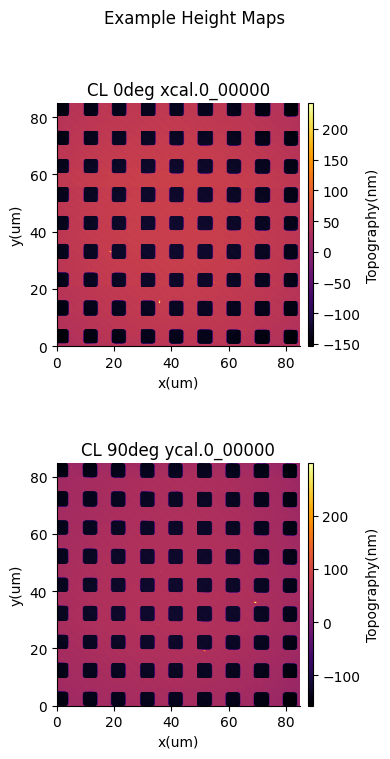

In [1]:
from spm_reader import SpmReader
from piblin.data import ExperimentSet

spm_filepaths = [r"../data/CL 0deg xcal.0_00000.spm", 
                 r"../data/CL 90deg ycal.0_00000.spm"]

spm_reader = SpmReader()

measurements = []
for filepath in spm_filepaths:
    measurements.extend(spm_reader.data_from_filepath(filepath, channels_to_read={"Height Sensor"}).measurements)

experiments = ExperimentSet(measurements=measurements, merge_redundant=False)
experiments.detail_to_condition("source_file_name_head")

f, a = experiments.visualize(total_figsize=(4, 8))
_ = f.suptitle("Example Height Maps")
_ = a[0].set_title(experiments[0].conditions["source_file_name_head"])
_ = a[1].set_title(experiments[1].conditions["source_file_name_head"])

### Process the Raw Height Maps

The `piblin` package also provides a framework for defining transforms of analytical data based on the "split, apply, combine" paradigm.

https://github.com/3M-Cloud/AdaraTransforms/blob/main/transforms/afmcbirlambda/app.py

In [2]:
from transforms import ScipyTransform, SubtractPlane, cast_to_int, Normalize

pipeline = ScipyTransform("ndimage.median_filter", size=10) + \
           SubtractPlane() + \
           Normalize() + \
           cast_to_int

processed_experiments = pipeline.apply_to(experiments, target_maximum=255)

ExperimentSet
-------------

Summary
-------
Number of Experiments: 2

Varied Conditions
-----------------
source_file_name_head

index	n_rep	source_file_name_head	Data Types	
0	1	CL 0deg xcal.0_00000	TwoDimensionalDataset: Topography=f(x, y)	
1	1	CL 90deg ycal.0_00000	TwoDimensionalDataset: Topography=f(x, y)	




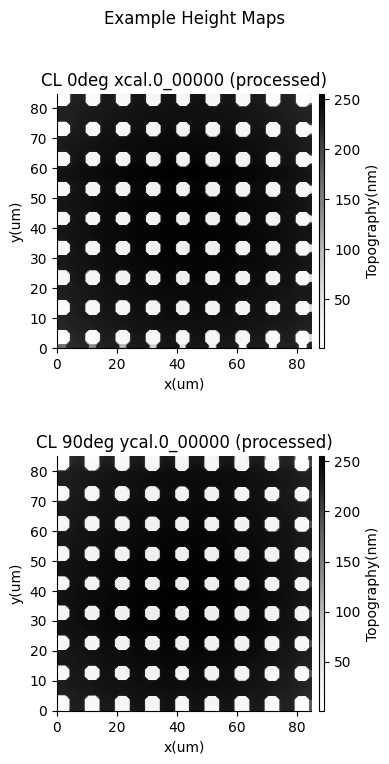

In [3]:
f, a = processed_experiments.visualize(total_figsize=(4, 8), cmap='Greys')
_ = f.suptitle("Example Height Maps")
_ = a[0].set_title(experiments[0].conditions["source_file_name_head"] + " (processed)")
_ = a[1].set_title(experiments[1].conditions["source_file_name_head"] + " (processed)")

### Save the Raw Height Maps as Images for Model Building

In [4]:
import numpy as np
from PIL import Image

for experiment in processed_experiments:
    for replicate in experiment.repetitions:
        image = Image.fromarray(np.rot90(replicate.datasets[0].z_values))
        output_filepath = replicate.details["source_file_path"].replace("spm", "png")
        image.save(output_filepath)

## SIFT-BOW

We first perform an embedding using SIFT BOW, with a latent dimension of size 32 and an arbitrary input size.
We show both the cosine similarity between image embeddings as well as a principal component analysis (PCA) plot of the embeddings.

In [1]:
from dino import DINO_inference
from siftBOW import siftBOW_inference
import os
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

SIFT_model = siftBOW_inference(cluster_npy='sift_bag_of_words_32.npy')

SIFT_embeddings = []
png_filepaths = [r"../data/CL 0deg xcal.0_00000.png", 
                 r"../data/CL 90deg ycal.0_00000.png"]
for i in png_filepaths:
    SIFT_embeddings.append(SIFT_model.infer(input_file=i).flatten())
SIFT_embeddings = np.array(SIFT_embeddings)

/data/meschw04/anaconda/envs/mol_env/lib/python3.11/site-packages/lightly/cli/train_cli.py:137: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="config", config_name="config")
/data/meschw04/anaconda/envs/mol_env/lib/python3.11/site-packages/lightly/cli/embed_cli.py:124: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='config', config_name='config')
/data/meschw04/anaconda/envs/mol_env/lib/python3.11/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.21. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==2.3.2
  warnings.warn(Warning(warning))
/data/meschw04/anaconda/envs/mol_env/lib/python3.11/site-packages

We compare the cosine distance from the embeddings between these two images.
This can be a helpful way to quickly recognize subsets of images that are similar to one another in a small subset.

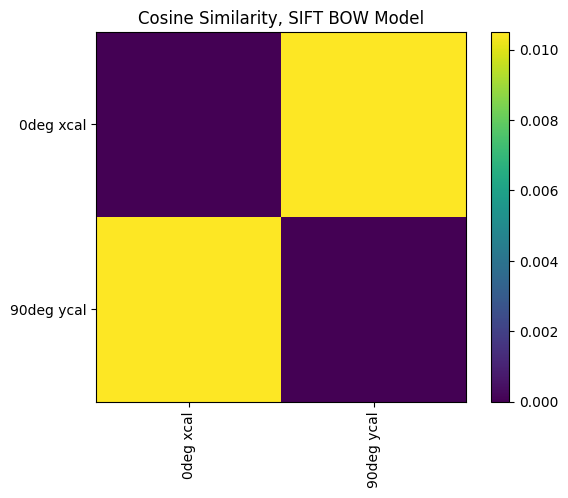

In [10]:
all_cos_distances = []
for i in SIFT_embeddings:
    cos_sub = []
    for j in SIFT_embeddings:
        cos_sub.append(cosine(i,j))
    all_cos_distances.append(cos_sub)
all_ticks = [i.replace('../data/CL ','').replace('.0_00000.png','') for i in png_filepaths]
plt.imshow(all_cos_distances)
plt.colorbar()
plt.xticks(range(len(all_ticks)),all_ticks,rotation=90)
plt.yticks(range(len(all_ticks)),all_ticks)
plt.title('Cosine Similarity, SIFT BOW Model')
plt.show()

We can also perform principal component analysis (PCA) on the embeddings. This can be an effective way to study clusters for similar morphologies on large image datasets.

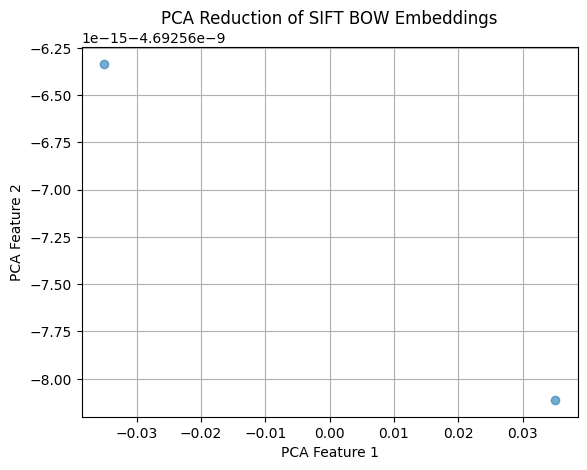

In [11]:
SIFT_PCA = PCA().fit_transform(SIFT_embeddings)
plt.scatter(SIFT_PCA.T[0],SIFT_PCA.T[1],alpha=0.6)
plt.grid()
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Reduction of SIFT BOW Embeddings')
plt.show()

## DINO
Similar to the SIFT-BOW comparisons, we can also use the `dino_in128_ls32.pth` file to embed these two images.
We use an input image standardized to size $128 \times 128$ and receive a vector of size 32 as a latent embedding.

In [7]:
DINO_model = DINO_inference(model_file='dino_in128_ls32.pth',input_size=128,latent_size=32)

png_filepaths = [r"../data/CL 0deg xcal.0_00000.png", 
                 r"../data/CL 90deg ycal.0_00000.png"]
DINO_embeddings = []
for i in png_filepaths:
    DINO_embeddings.append(DINO_model.infer(input_file=i).flatten())
DINO_embeddings = np.array(DINO_embeddings)

We can compare the cosine distance between these two embeddings, as we did with SIFT-BOW.

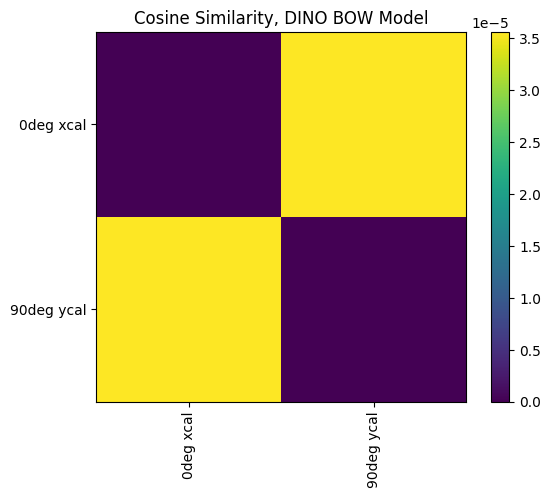

In [8]:
all_cos_distances = []
for i in DINO_embeddings:
    cos_sub = []
    for j in DINO_embeddings:
        cos_sub.append(cosine(i,j))
    all_cos_distances.append(cos_sub)
all_ticks = [i.replace('../data/CL ','').replace('.0_00000.png','') for i in png_filepaths]
plt.imshow(all_cos_distances)
plt.colorbar()
plt.xticks(range(len(all_ticks)),all_ticks,rotation=90)
plt.yticks(range(len(all_ticks)),all_ticks)
plt.title('Cosine Similarity, DINO BOW Model')
plt.show()

We can plot the PCA dimensional reduction of our size-32 latent space, as we did with the SIFT-BOW model.

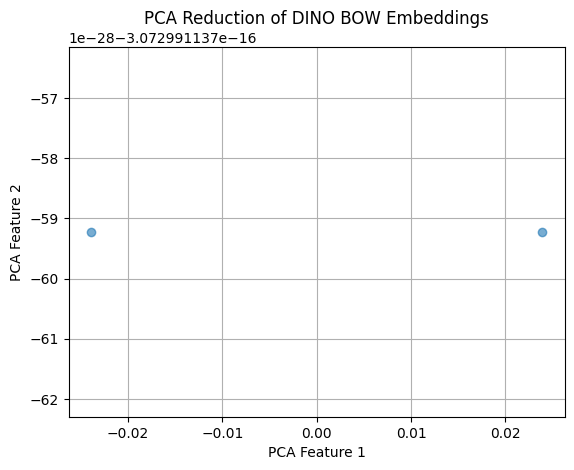

In [9]:
DINO_PCA = PCA().fit_transform(DINO_embeddings)
plt.scatter(DINO_PCA.T[0],DINO_PCA.T[1],alpha=0.6)
plt.grid()
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA Reduction of DINO BOW Embeddings')
plt.show()

We include a script, `model_runner.py`, which can be used to train a DINO model. For a given input folder `input_folder`, training can be called from the command line as:

```python model_runner.py --model dino --in_dir input_folder```

By default, the input size is set to 128, the latent embedding size is set to 32, the model is trained for 10 epochs with 64 cores and a batch size of 256. Two files are created: `model.pth` contains the weights, `embeddings.csv` contains the latent embeddings of all topograpies.